<a href="https://colab.research.google.com/github/ValentinKarev/ML_for_DNK/blob/main/%D0%A7%D0%B8%D1%85%D1%83%D0%B0%D1%85%D1%83%D0%B0%20%D0%B8%20%D0%BC%D0%B0%D1%84%D1%84%D0%B8%D0%BD%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание 3.3 - Тренируем свои сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [1]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [2]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

In [3]:
!pip install -q opendatasets

In [ ]:
#username: valentinkarev
#key: 45b0c3bb27239cb6f4890b8d0e7ede25

In [4]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: valentinkarev
Your Kaggle Key: ··········


100%|██████████| 474M/474M [00:28<00:00, 17.2MB/s]


In [5]:
path_train = '/content/muffin-vs-chihuahua-image-classification/train'
path_test = '/content/muffin-vs-chihuahua-image-classification/test'

# Загружаем данные

In [6]:
# First, lets load the dataset
data_train = dset.ImageFolder(path_train,
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47], std=[0.20,0.20,0.20])
                       ])
                      )
data_test = dset.ImageFolder(path_test, transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47], std=[0.20,0.20,0.20])
                       ]))

In [7]:
data_train[0]

(tensor([[[2.8500, 2.8500, 2.8500,  ..., 2.8500, 2.8500, 2.8500],
          [2.8500, 2.8500, 2.8500,  ..., 2.8500, 2.8500, 2.8500],
          [2.8500, 2.8500, 2.8500,  ..., 2.8500, 2.8500, 2.8500],
          ...,
          [1.7912, 1.8500, 1.8892,  ..., 2.8500, 2.8500, 2.8500],
          [2.6735, 2.5951, 2.7324,  ..., 2.8500, 2.8500, 2.8500],
          [2.8304, 2.6735, 2.7912,  ..., 2.8500, 2.8500, 2.8500]],
 
         [[2.8000, 2.8000, 2.8000,  ..., 2.8000, 2.8000, 2.8000],
          [2.8000, 2.8000, 2.8000,  ..., 2.8000, 2.8000, 2.8000],
          [2.8000, 2.8000, 2.8000,  ..., 2.8000, 2.8000, 2.8000],
          ...,
          [1.7412, 1.8000, 1.8392,  ..., 2.8000, 2.8000, 2.8000],
          [2.6235, 2.5451, 2.6824,  ..., 2.8000, 2.8000, 2.8000],
          [2.7804, 2.6235, 2.7412,  ..., 2.8000, 2.8000, 2.8000]],
 
         [[2.6500, 2.6500, 2.6500,  ..., 2.6500, 2.6500, 2.6500],
          [2.6500, 2.6500, 2.6500,  ..., 2.6500, 2.6500, 2.6500],
          [2.6500, 2.6500, 2.6500,  ...,

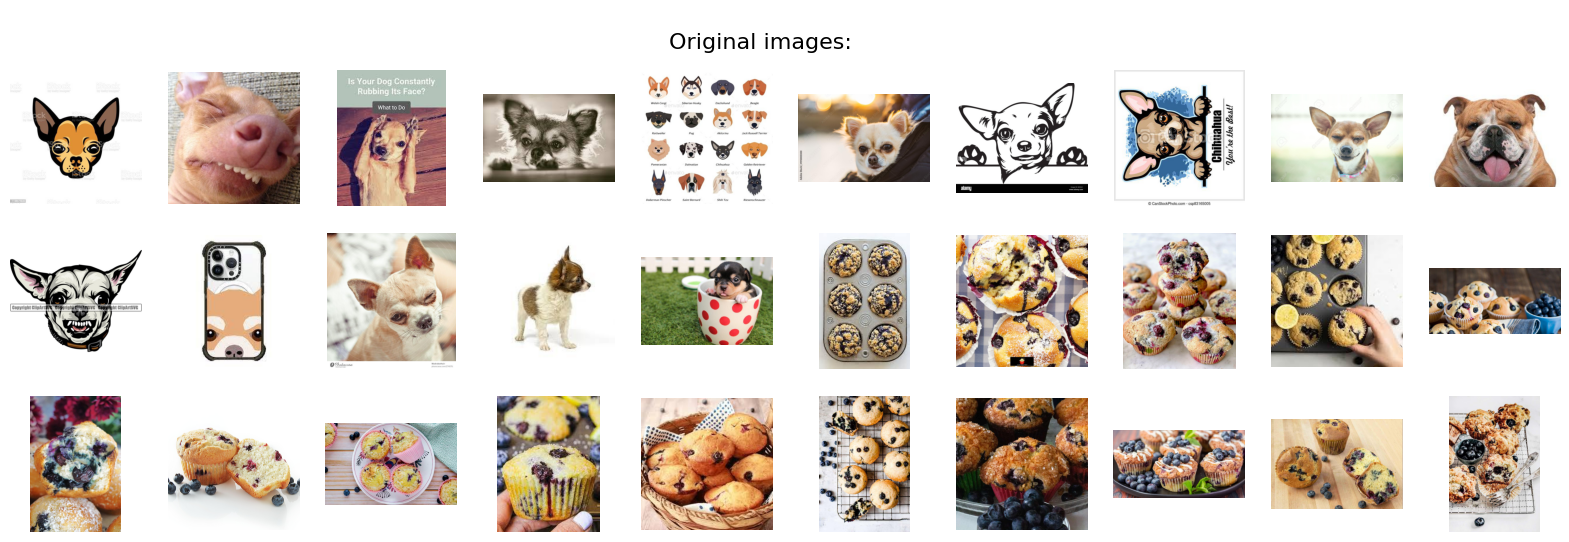

In [15]:
rows = 3
cols = 10

fig = plt.figure(figsize=(20, 6))
fig.suptitle('\nOriginal images:', fontsize=16)

i=0

for (x, y) in dset.ImageFolder(path_train):
    if i == rows * cols:
        break
    if i > 14 and y == 1:
        plt.subplot(rows, cols, i+1)
        plt.grid(False)
        plt.imshow(x)
        plt.axis('off')
        i+=1
    if i < 15 and y == 0:
        plt.subplot(rows, cols, i+1)
        plt.grid(False)
        plt.imshow(x)
        plt.axis('off')
        i+=1

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [ ]:
batch_size = 24

data_size = len(data_train)
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=val_sampler)

In [ ]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [ ]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            Flattener(),
            nn.Linear(12544, 10), #Здесь пишем свои модели
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [ ]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None, scheduler_loss=False):
    train_loss_history = []
    train_acc_history = []

    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        model.train() # Enter train mode

        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)

            prediction = model(x_gpu)
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]

            loss_accum += float(loss_value)

        train_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples

        val_loss, val_accuracy = compute_loss_accuracy(model, val_loader)

        if scheduler is not None:
            if scheduler_loss:
                scheduler.step(val_loss)
            else:
                scheduler.step()

        train_loss_history.append(train_loss)
        train_acc_history.append(train_accuracy)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_accuracy)

        print("Epoch #%s - train loss: %f, accuracy: %f | val loss: %f, accuracy: %f" % (epoch, train_loss, train_accuracy, val_loss, val_accuracy))

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


def compute_loss_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader

    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode

    loss_accum = 0.0
    correct = 0.0
    total = 0.0
    for i, (x, y) in enumerate(loader):
        x_gpu = x.to(device)
        y_gpu = y.to(device)

        y_probs = model(x_gpu)
        y_hat = torch.argmax(y_probs, 1)

        loss_value = loss(y_probs, y_gpu)
        loss_accum += float(loss_value)

        correct += float(torch.sum(y_hat == y_gpu))
        total += y_gpu.shape[0]

    return loss_accum / (i + 1), correct / total


Epoch #0 - train loss: 0.743513, accuracy: 0.720608 | val loss: 0.542858, accuracy: 0.786398
Epoch #1 - train loss: 0.436652, accuracy: 0.843558 | val loss: 0.401969, accuracy: 0.847232
Epoch #2 - train loss: 0.350171, accuracy: 0.874316 | val loss: 0.356422, accuracy: 0.864320
Epoch #3 - train loss: 0.305119, accuracy: 0.890465 | val loss: 0.322482, accuracy: 0.880383


KeyboardInterrupt: ignored

In [ ]:
%time train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [ ]:
tfs = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47], std=[0.20,0.20,0.20])
])

# Create augmented train dataset
data_aug_train = dset.ImageFolder(path_train,
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, sampler=train_sampler)

Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

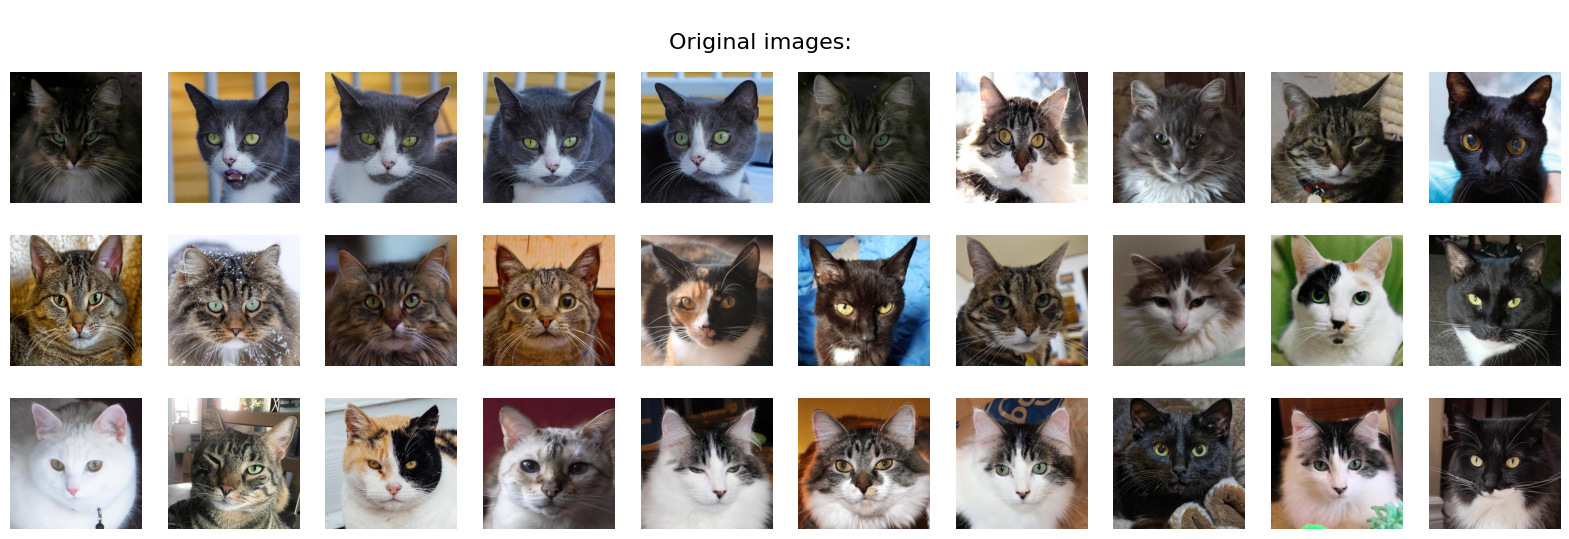

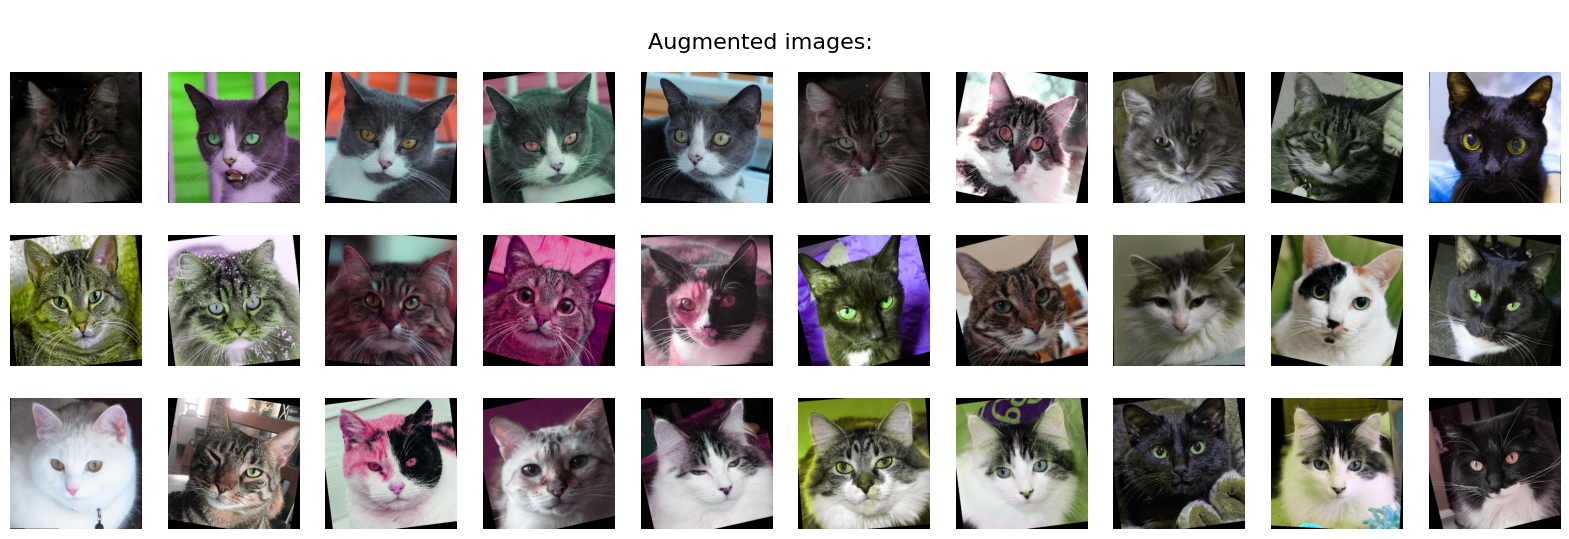

In [ ]:
# Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

rows = 3
cols = 10

fig = plt.figure(figsize=(20, 6))
fig.suptitle('\nOriginal images:', fontsize=16)

i = 0

for (x, y) in dset.ImageFolder(path_train):
    if i == rows * cols:
        break
    if i > 14 and y == 1:
        plt.subplot(rows, cols, i+1)
        plt.grid(False)
        plt.imshow(x)
        plt.axis('off')
        i+=1
    if i < 15 and y == 0:
        plt.subplot(rows, cols, i+1)
        plt.grid(False)
        plt.imshow(x)
        plt.axis('off')
        i+=1


# -----------------------------------------------------------------


tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15)
])
data_aug_vis = dset.ImageFolder(path_train,
                       transform=tfs
                      )

fig = plt.figure(figsize=(20, 6))
fig.suptitle('\nAugmented images:', fontsize=16)

i = 0

for (x, y) in data_aug_vis:
    if i == rows * cols:
        break
    if i > 14 and y == 1:
        plt.subplot(rows, cols, i+1)
        plt.grid(False)
        plt.imshow(x)
        plt.axis('off')
        i+=1
    if i < 15 and y == 0:
        plt.subplot(rows, cols, i+1)
        plt.grid(False)
        plt.imshow(x)
        plt.axis('off')
        i+=1

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

In [ ]:
tfs = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47], std=[0.20,0.20,0.20])
])

data_aug_train = dset.ImageFolder(path_train,
                       transform=tfs
                      )
train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, sampler=train_sampler)

In [ ]:
# Finally, let's train with augmentations!
# Note we shouldn't use augmentations on validation

%time train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Epoch #0 - train loss: 0.745482, accuracy: 0.677888 | val loss: 0.412972, accuracy: 0.850649
Epoch #1 - train loss: 0.619556, accuracy: 0.736500 | val loss: 0.441841, accuracy: 0.822625
Epoch #2 - train loss: 0.565673, accuracy: 0.764183 | val loss: 0.464390, accuracy: 0.816473
Epoch #3 - train loss: 0.538125, accuracy: 0.781784 | val loss: 0.369981, accuracy: 0.865687
Epoch #4 - train loss: 0.507286, accuracy: 0.791695 | val loss: 0.458417, accuracy: 0.810663
CPU times: user 12min 24s, sys: 4.51 s, total: 12min 29s
Wall time: 12min 32s


# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

# Подбор гиперпараметров

In [ ]:
model = nn.Sequential(
    # 32x32@3 => 32x32@16
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=2),
    nn.BatchNorm2d(num_features=16),
    nn.ReLU(inplace=True),

    # 32x32@16 => 16x16@16
    nn.MaxPool2d(kernel_size=2),

    # 16x16@16 => 14x14@32
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
    nn.BatchNorm2d(num_features=32),
    nn.ReLU(inplace=True),

    # 14x14@32 => 7x7@32
    nn.MaxPool2d(kernel_size=2),

    # 7x7@32 => 5x5@64
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.BatchNorm2d(num_features=64),
    nn.ReLU(inplace=True),

    Flattener(),

    nn.Linear(in_features=5*5*64, out_features=128),
    nn.BatchNorm1d(num_features=128),
    nn.ReLU(inplace=True),

    nn.Linear(in_features=128, out_features=10)
)

model.type(torch.cuda.FloatTensor)
model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.333, patience=3, verbose=True)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

%time train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model, train_aug_loader, val_loader, loss, optimizer, 10, \
                                                                                             scheduler=scheduler, scheduler_loss=True)

Epoch #0 - train loss: 0.640532, accuracy: 0.803058 | val loss: 0.390802, accuracy: 0.883626
Epoch #1 - train loss: 0.390913, accuracy: 0.882128 | val loss: 0.332090, accuracy: 0.899188
Epoch #2 - train loss: 0.341951, accuracy: 0.897843 | val loss: 0.312100, accuracy: 0.906832
Epoch #3 - train loss: 0.319555, accuracy: 0.902774 | val loss: 0.313645, accuracy: 0.905672
Epoch #4 - train loss: 0.303991, accuracy: 0.909770 | val loss: 0.287571, accuracy: 0.913043
Epoch #5 - train loss: 0.291799, accuracy: 0.913200 | val loss: 0.283191, accuracy: 0.916388
Epoch #6 - train loss: 0.282532, accuracy: 0.915418 | val loss: 0.276463, accuracy: 0.920415
Epoch #7 - train loss: 0.277374, accuracy: 0.917090 | val loss: 0.284926, accuracy: 0.916183
Epoch #8 - train loss: 0.272345, accuracy: 0.919974 | val loss: 0.278442, accuracy: 0.918231
Epoch #9 - train loss: 0.268133, accuracy: 0.920861 | val loss: 0.274184, accuracy: 0.919528
CPU times: user 8min 33s, sys: 10 s, total: 8min 43s
Wall time: 8min 4

In [ ]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

# Use grid search or random search and record all runs in run_record dictionnary
# Important: perform search in logarithmic space!

HyperParams = namedtuple("Hyperparams", ['learning_rate', 'reg_strength', 'anneal_factor', 'anneal_patience', 'epochs'])
RunResult = namedtuple("RunResult", ['model', 'train_loss_history', 'train_acc_history', 'val_loss_history', 'val_acc_history', 'final_val_accuracy'])

def search(stats, learning_rates, reg_strengths, anneal_factor=0.333, anneal_patience=3, epochs=15):
    for learning_rate in learning_rates:
        for reg_strength in reg_strengths:

            model = nn.Sequential(
                # 32x32@3 => 32x32@16
                nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=2),
                nn.BatchNorm2d(num_features=16),
                nn.ReLU(inplace=True),

                # 32x32@16 => 16x16@16
                nn.MaxPool2d(kernel_size=2),

                # 16x16@16 => 14x14@32
                nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
                nn.BatchNorm2d(num_features=32),
                nn.ReLU(inplace=True),

                # 14x14@32 => 7x7@32
                nn.MaxPool2d(kernel_size=2),

                # 7x7@32 => 5x5@64
                nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                nn.BatchNorm2d(num_features=64),
                nn.ReLU(inplace=True),

                Flattener(),

                nn.Linear(in_features=5*5*64, out_features=128),
                nn.BatchNorm1d(num_features=128),
                nn.ReLU(inplace=True),

                nn.Linear(in_features=128, out_features=10)
            )

            model.type(torch.cuda.FloatTensor)
            model.to(device)

            loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
            optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg_strength)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=anneal_factor, patience=anneal_patience, verbose=True)

            key = HyperParams(learning_rate, reg_strength, anneal_factor, anneal_patience, epochs)

            print('Training model: %s' % str(key))

            results = train_model(model, train_aug_loader, val_loader, loss, optimizer, epochs, scheduler=scheduler, scheduler_loss=True)
            train_loss_history, train_acc_history, val_loss_history, val_acc_history = results
            final_val_accuracy = val_acc_history[-1]

            value = RunResult(model, train_loss_history, train_acc_history, val_loss_history, val_acc_history, final_val_accuracy)
            stats[key] = value

            print('\n')


# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {}

In [ ]:
learning_rates = [1e-3]
reg_strengths = [1e-4]

search(run_record, learning_rates, reg_strengths, epochs=20)

Training model: Hyperparams(learning_rate=0.001, reg_strength=0.0001, anneal_factor=0.333, anneal_patience=3, epochs=20)
Epoch #0 - train loss: 0.623288, accuracy: 0.808910 | val loss: 0.376855, accuracy: 0.884308
Epoch #1 - train loss: 0.378166, accuracy: 0.884739 | val loss: 0.321350, accuracy: 0.900826
Epoch #2 - train loss: 0.318548, accuracy: 0.903696 | val loss: 0.311242, accuracy: 0.905808
Epoch #3 - train loss: 0.282002, accuracy: 0.915179 | val loss: 0.281957, accuracy: 0.917548
Epoch #4 - train loss: 0.256844, accuracy: 0.923455 | val loss: 0.287205, accuracy: 0.914204
Epoch #5 - train loss: 0.237785, accuracy: 0.928181 | val loss: 0.260653, accuracy: 0.923077
Epoch #6 - train loss: 0.217082, accuracy: 0.932959 | val loss: 0.269327, accuracy: 0.921780
Epoch #7 - train loss: 0.204553, accuracy: 0.938419 | val loss: 0.269908, accuracy: 0.920688
Epoch #8 - train loss: 0.191018, accuracy: 0.941508 | val loss: 0.274482, accuracy: 0.920278
Epoch     9: reducing learning rate of gro

In [ ]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result

print("Best validation accuracy: %f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))

best_model = run_record[best_hyperparams].model

Best validation accuracy: 0.929902, best hyperparams: Hyperparams(learning_rate=0.001, reg_strength=0.0001, anneal_factor=0.333, anneal_patience=3, epochs=20)


# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [ ]:
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_loss, test_accuracy = compute_loss_accuracy(best_model, test_loader)
print("Test loss: %f, accuracy: %f" % (test_loss, test_accuracy))

Test loss: 0.269881, accuracy: 0.930124
